---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [1]:
# Load packages
import random
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import numpy as np
import os
import cv2 
import skimage
from skimage import exposure
from skimage import transform
from sklearn.utils import shuffle

# Set paths to training, validation, and test (pickled) data
training_file = "./traffic-signs-data/train.p"
validation_file= "./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape

# How many unique classes/labels there are in the dataset?
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", X_valid.shape[0])
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (34799, 32, 32, 3)
Number of classes = 43


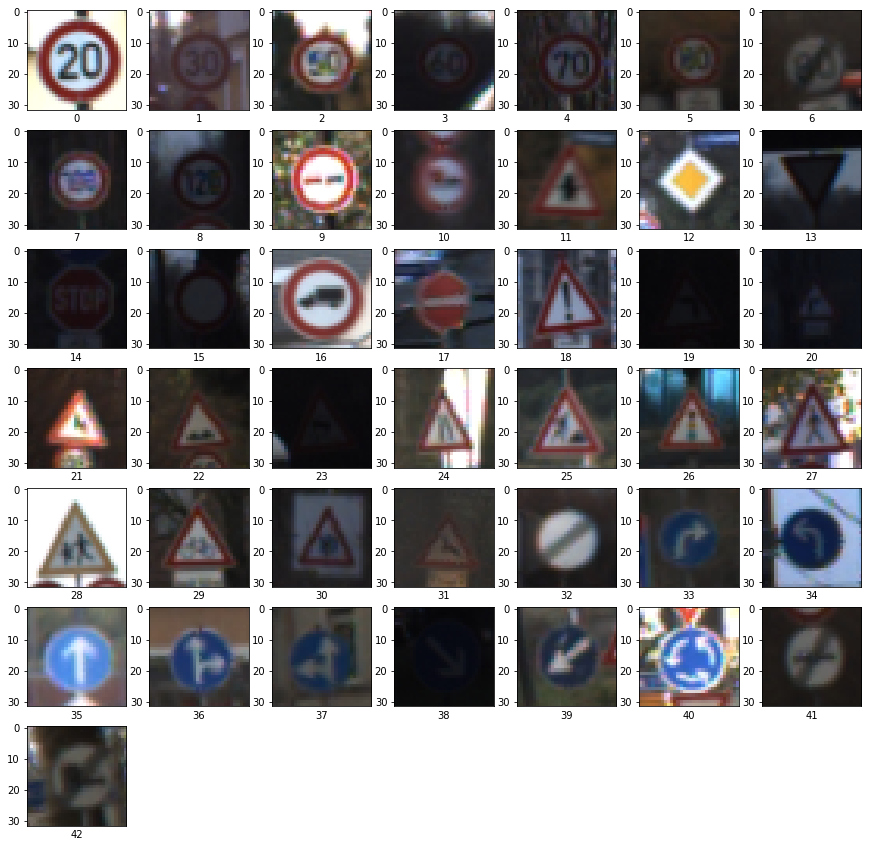

In [3]:
# Plot all the figures
fig = plt.figure(figsize = (15,15))
for i in range(n_classes):
        axes = fig.add_subplot(7,7,i+1)
        ind = np.where(y_train == i)[0][5]
        axes.imshow(X_train[ind])
        axes.set_xlabel(y_train[ind])
        plt.xticks(np.array([]))

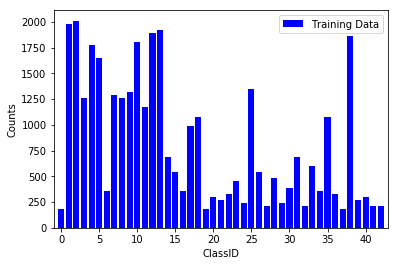

In [3]:
# Explore the training and testing dataset
_,train_counts = np.unique(y_train, return_counts = True)   # Find unique values and their counts

# Plot histogram of different training classes 
plt.bar(range(43), train_counts, align='center',  color='b', label='Training Data')
plt.xlabel('ClassID')
plt.ylabel('Counts')
plt.xlim([-1, 43])
plt.legend()

In [4]:
def focus_ROI(img,coords,size):
    # Focus on the region of interest in each image
    # INPUT:
    # img = an image
    # coords = coordinates of the top left and bottom left corners of bounding box
    # size = size of original image
    # RETURN:
    # Image of size 32x32, focused on region of interest
    
    if (coords[1]>size[0] or coords[3]>size[0] or coords[1]>size[1] or coords[2]>size[1]):
        return img

    img0 = img.copy()
        
        
    width_scale, height_scale = 32/size[0], 32/size[1]
    xmin = np.floor(coords[0]*width_scale).astype(np.uint32)
    ymin = np.floor(coords[1]*height_scale).astype(np.uint32)
    xmax = np.ceil(coords[2]*width_scale).astype(np.uint32)
    ymax = np.ceil(coords[3]*height_scale).astype(np.uint32)
    
    # Crop images
    img2 = img0[xmin:xmax, ymin:ymax]

    resize_x, resize_y = 32/img2.shape[1], 32/img2.shape[0]
    
    # Reshape so the output is 32 x 32 x 3
    return cv2.resize(img2,None,fx=resize_x, fy=resize_y, interpolation = cv2.INTER_CUBIC)

In [ ]:
def preprocess_data(X_train,X_valid,X_test):
    # Preprocessing of training/validation/testing data using:
    # 1. Focus on region of interest
    # 2. Convert to grayscale
    # 3. Adaptive historgram equalization
    # 4. Normalized to (-0.5, 0.5)
    # INPUT:
    # X_train, X_valid, X_test = RGB training, validation, test data of size (32x32x3)
    # RETURNS:
    # Xtrain, Xvalid, Xtest = preprocessed imaged  
    
    
    Xt2 = np.zeros(shape = (X_train.shape[0],32,32))
    Xv2 = np.zeros(shape = (X_valid.shape[0],32,32))
    Xtest2 = np.zeros(shape = (X_test.shape[0],32,32))  

    # Preprocess training data
    jj = 0
    for img in X_train:
        a1 = focus_ROI(img, train['coords'][jj], train['sizes'][jj])
        a2 = cv2.cvtColor(a1, cv2.COLOR_RGB2GRAY)
        Xt2[jj,:] = exposure.equalize_adapthist(a2,8) - 0.5
        jj += 1

    # Preprocess validation data
    kk = 0
    for img in X_valid:
        b1 = focus_ROI(img, valid['coords'][kk], valid['sizes'][kk]) 
        b2 = cv2.cvtColor(b1, cv2.COLOR_RGB2GRAY)
        Xv2[kk,:] = exposure.equalize_adapthist(b2,8) - 0.5
        kk += 1

    # Preprocess testing data
    ii = 0
    for img in X_test:
        c1 = focus_ROI(img, test['coords'][ii], test['sizes'][ii])
        c2 = cv2.cvtColor(c1, cv2.COLOR_RGB2GRAY)
        Xtest2[ii,:] = exposure.equalize_adapthist(c2,8) - 0.5
        ii += 1


    # Reshape into (num_images x 32 x 32 x 1), which is required for tensorflow 
    Xtrain = Xt2.reshape(-1,32,32,1)
    Xvalid = Xv2.reshape(-1,32,32,1)
    Xtest  = Xtest2.reshape(-1,32,32,1)  
    
    return Xtrain, Xvalid, Xtest

In [6]:
# Generate (and picked), or load, pre-processed data
filename = 'preprocessed_data6.pickle'

if os.path.exists(filename):
    # Pre-processed data already exists - load pickle
    print('%s already exists: skipping pickling and loading data.' %filename)
    
    with open(filename, mode='rb') as f:
        saved_data = pickle.load(f)
        Xtrain = saved_data['Train_data']
        y_train = saved_data['Train_labels']
        Xvalid = saved_data['Valid_data']
        y_valid = saved_data['Valid_labels']
        Xtest = saved_data['Test_data']
        y_test = saved_data['Test_labels']

else: 
    
    Xtrain, Xvalid, Xtest = preprocess_data(X_train, X_valid, X_test) 
    
    # Create list of datasets, and pickle 
    A = {'Train_data': Xtrain,
         'Train_labels': y_train,
         'Valid_data': Xvalid,
         'Valid_labels': y_valid,
         'Test_data': Xtest,
         'Test_labels': y_test}

    with open(filename, 'wb') as f:
        pickle.dump(A, f, protocol = pickle.HIGHEST_PROTOCOL)
    print('%s is now pickled' %(filename))

preprocessed_data6.pickle already exists: skipping pickling and loading data.


In [ ]:
# Show two images before vs. after pre-processing
jj = random.randint(0, len(X_train))
kk = random.randint(0, len(X_valid))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 4))
axes[0,0].imshow(X_train[jj])
axes[0,1].imshow(Xtrain[jj,:,:,0], cmap = 'gray')
axes[1,0].imshow(X_valid[kk])
axes[1,1].imshow(Xvalid[kk,:,:,0], cmap = 'gray')

In [7]:
# Data augmentation: if the dataset has a low proportion of a certain class, then generate
# new images of that class by rotating an image from that class from -25 degrees to +25 degrees

proportions = np.zeros(43)
for i in np.unique(y_train):
    # Proportion of images of class i in full dataset
    proportions[i] = len(y_train[y_train == i]) / n_train

threshold = 0.06
for i in range(n_classes):
    # Check whether class i has fewer than threshold (6%) of images
    if proportions[i] < threshold:
        # Augment the dataset by rotating image through [-25, +25] degrees
        num_augmentations = (np.floor(threshold*n_train) - len(y_train[y_train == i])).astype(np.int32)
        print('Augmenting label %s, which is missing %s images' %(i, num_augmentations))

        p2 = np.zeros(shape = (num_augmentations,32,32,1))
        y1 = i*np.ones(num_augmentations, dtype = np.uint8)
        
        p1 = Xtrain[np.where(y_train == i)[0][0]]  # Sample image from the class
        for j in range(num_augmentations):
            # Rotate image
            p2[j] = skimage.transform.rotate(p1,-25 + 50*j/num_augmentations, resize = False)

        # Augmnet datasets by rotated images
        Xtrain = np.concatenate((Xtrain,p2), axis = 0)
        y_train = np.concatenate((y_train,y1), axis = 0)

print('\nNew train set has %s rows' %(Xtrain.shape[0]))

Augmenting label 0, which is missing 1907 images
Augmenting label 1, which is missing 107 images
Augmenting label 2, which is missing 77 images
Augmenting label 3, which is missing 827 images
Augmenting label 4, which is missing 317 images
Augmenting label 5, which is missing 437 images
Augmenting label 6, which is missing 1727 images
Augmenting label 7, which is missing 797 images
Augmenting label 8, which is missing 827 images
Augmenting label 9, which is missing 767 images
Augmenting label 10, which is missing 287 images
Augmenting label 11, which is missing 917 images
Augmenting label 12, which is missing 197 images
Augmenting label 13, which is missing 167 images
Augmenting label 14, which is missing 1397 images
Augmenting label 15, which is missing 1547 images
Augmenting label 16, which is missing 1727 images
Augmenting label 17, which is missing 1097 images
Augmenting label 18, which is missing 1007 images
Augmenting label 19, which is missing 1907 images
Augmenting label 20, wh

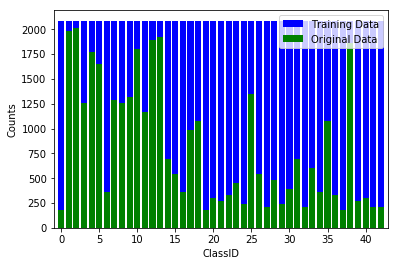

In [8]:
# Plot histograph of augmented dataset
_,train_counts = np.unique(y_train, return_counts = True)
_,train_counts_original = np.unique(train['labels'], return_counts = True)

plt.bar(range(43), train_counts, align='center',  color='b', label='Training Data')
plt.bar( np.arange( 43 ), train_counts_original, align='center', color='g', label='Original Data')
plt.xlabel('ClassID')
plt.ylabel('Counts')
plt.xlim([-1, 43])
plt.legend()

In [ ]:
# Build the LeNet CNN architecture
EPOCHS = 30
BATCH_SIZE = 128

def LeNet(x):
    # Define and construct the LeNet neural network, with extra flexibility for dropouts
    # INPUT:
    # x = a grayscale image of size (N, 32, 32, 1)
    # RETURNS:
    # logits
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # LAYER 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    weights1 = tf.Variable(tf.truncated_normal((5,5,1,6), mean = mu, stddev = sigma, dtype = tf.float32))
    biases1 = tf.Variable(tf.zeros(6), dtype = tf.float32)
    strides1 = [1,1,1,1]
    
    # Run a 2D convolution and then apply dropout
    conv1 = tf.nn.conv2d(x, weights1,strides1,padding = 'VALID')
    conv1 = tf.nn.dropout(conv1, keep_prob1)
    
    # Activation using RELU
    layer1 = tf.nn.relu(tf.add(conv1,biases1))  
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    ksize1 = [1,2,2,1]
    strides_pool1 = [1,2,2,1]
    pool1 = tf.nn.max_pool(layer1, ksize = ksize1, strides = strides_pool1, padding = 'VALID')
    pool1 = tf.nn.dropout(pool1, keep_prob2)
    
    # LAYER 2: Convolutional. Output = 10x10x16.
    weights2 = tf.Variable(tf.truncated_normal((5,5,6,16), mean = mu, stddev = sigma, dtype = tf.float32))
    biases2  = tf.Variable(tf.zeros([16], dtype = tf.float32))
    strides2 = [1,1,1,1]
    conv2    = tf.nn.conv2d(pool1, weights2, strides = strides2, padding = 'VALID')
    
    # Activation.
    layer2 = tf.nn.relu(tf.add(conv2,biases2))
    layer2 = tf.nn.dropout(layer2,keep_prob3)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    ksize2 = [1,2,2,1]
    strides_pool2 = [1,2,2,1]
    pool2 = tf.nn.max_pool(layer2, ksize = ksize2, strides = strides_pool2, padding = 'VALID')
    pool2 = tf.nn.dropout(pool2, keep_prob4)
    
    #Flatten. Input = 5x5x16. Output = 400.
    flat1 = flatten(pool2)
    flat1 = tf.nn.dropout(flat1,keep_prob5)
    
    # LAYER 3: Fully Connected. Input = 400. Output = 120.
    w3 = tf.Variable(tf.truncated_normal((400,120), mean = mu, stddev = sigma, dtype = tf.float32))
    b3 = tf.Variable(tf.zeros(120), dtype = tf.float32)
    
    # Activation.
    o3a = tf.add(tf.matmul(flat1,w3),b3)
    o3  = tf.nn.relu(o3a)
    o3 = tf.nn.dropout(o3,keep_prob6)
    
    # LAYER 4: Fully Connected. Input = 120. Output = 84.
    w4 = tf.Variable(tf.truncated_normal((120,84), mean = mu, stddev = sigma, dtype = tf.float32))
    b4 = tf.Variable(tf.zeros(84), dtype = tf.float32) 
    
    # Activation.
    o4a = tf.add(tf.matmul(o3,w4),b4)
    o4  = tf.nn.relu(o4a)
        
    # LAYER 5: Fully Connected. Input = 84. Output = 84.
    w5 = tf.Variable(tf.truncated_normal((84,43), mean = mu, stddev = sigma, dtype = tf.float32))
    b5 = tf.Variable(tf.zeros(43), dtype = tf.float32)
    logits  = tf.add(tf.matmul(o4,w5), b5)

    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [11]:
# Define variables to be used within LeNet CNN
x = tf.placeholder(tf.float32, (None, 32, 32,1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

# Add in extra flexibility with placeholders
keep_prob1 = tf.placeholder(tf.float32)
keep_prob2 = tf.placeholder(tf.float32)
keep_prob3 = tf.placeholder(tf.float32)
keep_prob4 = tf.placeholder(tf.float32)
keep_prob5 = tf.placeholder(tf.float32)
keep_prob6 = tf.placeholder(tf.float32)

# Define the optimizer 
rate = 0.001                   # Learning rate       
logits = LeNet(x)              # Run LeNet (with the placeholders as inputs)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)  # Compute cross-entropy with softmax
loss_operation = tf.reduce_mean(cross_entropy)     # This is the loss to be minimized

optimizer = tf.train.AdamOptimizer(learning_rate = rate)  # Build the optimizer
training_operation = optimizer.minimize(loss_operation)   # Run optimizer to minimize loss


In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1)) # Count number of correct predictions in this batch
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) # Compute average
saver = tf.train.Saver()                                                     # Save model

def evaluate(X_data, y_data, kp1, kp2, kp3, kp4, kp5, kp6):
    # Run a TF session and compute the accuracy of each batch
    # INPUT:
    # X_data, y_data = Input training/valuation data, and corresponding labels
    # kp1,..,kp6 = keep probabilities 1-6, for dropout
    # RETURN:
    # accuracy over entire training/validation set

    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        # Feed TF CNN data in small batches of size BATCH_SIZE (global variable)
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]

        # Now run TF session to return accuracy_prediction, defined above
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, 
                                                           keep_prob1: kp1,
                                                           keep_prob2: kp2,
                                                           keep_prob3: kp3,
                                                           keep_prob4: kp4,
                                                           keep_prob5: kp5,
                                                           keep_prob6: kp6})
        total_accuracy += (accuracy * len(batch_x))

    return total_accuracy / num_examples

In [14]:
# Run the TF session in batches and minimize loss

# Make lists to keep track of training and validation accuracy
training_accuracy   = list()
validation_accuracy = list()

with tf.Session() as sess:
    # Open a TF session and initialize variables
    sess.run(tf.global_variables_initializer())

    num_examples = len(Xtrain)
    print("Training...")
    print()

    for i in range(EPOCHS):
        # Shuffle the training set
        XX_train, yy_train = shuffle(Xtrain, y_train)

        for offset in range(0, num_examples, BATCH_SIZE):
            # Train the CNN in batches
            end = offset + BATCH_SIZE
            batch_x, batch_y = XX_train[offset:end], yy_train[offset:end]

            # Train CNN model
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,
                                                    keep_prob1: 1,
                                                    keep_prob2: 0.9,
                                                    keep_prob3: 1,
                                                    keep_prob4: 0.9,
                                                    keep_prob5: 1,
                                                    keep_prob6: 1})
            
        # Compute the training and validation accuracy
        ta = evaluate(Xtrain, y_train, 1,0.9,1,0.9,1,1)
        va = evaluate(Xvalid, y_valid, 1,1,1,1,1,1) # Recall that dropout is NOT used during validation

        # Print results
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(ta))
        print("Validation Accuracy = {:.3f}".format(va))
        print()
        validation_accuracy.append(va) 
        training_accuracy.append(ta) 
        
    # Save the model
    saver.save(sess, './lenet10')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.955
Validation Accuracy = 0.871

EPOCH 2 ...
Training Accuracy = 0.978
Validation Accuracy = 0.933

EPOCH 3 ...
Training Accuracy = 0.986
Validation Accuracy = 0.947

EPOCH 4 ...
Training Accuracy = 0.988
Validation Accuracy = 0.949

EPOCH 5 ...
Training Accuracy = 0.990
Validation Accuracy = 0.950

EPOCH 6 ...
Training Accuracy = 0.993
Validation Accuracy = 0.955

EPOCH 7 ...
Training Accuracy = 0.994
Validation Accuracy = 0.961

EPOCH 8 ...
Training Accuracy = 0.995
Validation Accuracy = 0.962

EPOCH 9 ...
Training Accuracy = 0.995
Validation Accuracy = 0.965

EPOCH 10 ...
Training Accuracy = 0.996
Validation Accuracy = 0.968

EPOCH 11 ...
Training Accuracy = 0.996
Validation Accuracy = 0.968

EPOCH 12 ...
Training Accuracy = 0.996
Validation Accuracy = 0.965

EPOCH 13 ...
Training Accuracy = 0.996
Validation Accuracy = 0.963

EPOCH 14 ...
Training Accuracy = 0.997
Validation Accuracy = 0.960

EPOCH 15 ...
Training Accuracy = 0.997
Valid

In [15]:
# Test the model on the (previously pre-processed) training set

with tf.Session() as sess:
    # Restore the model to the last checkpoint
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # Evaluate the accuracy on the test set 
    test_accuracy = evaluate(Xtest, y_test,1,1,1,1,1,1) # Again, no dropout in the test run
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.960


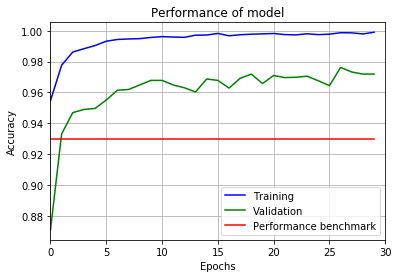

In [75]:
# Plot the accuracy of the training, validation, and test sets over EPOCHs. 
# Note: 1) the goal of the exercise was to beat 93% accuracy. 
# 2) Without any image pre-processing or LeNet modifications, accuracy = 87% 
plt.plot(range(EPOCHS), training_accuracy,  color='b', label='Training')
plt.plot(range(EPOCHS), validation_accuracy,  color='g', label='Validation')
plt.plot(range(EPOCHS), 0.93*np.ones(EPOCHS),  color='r', label='Performance benchmark')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Performance of model')
plt.xlim([0, EPOCHS])
plt.grid(True)
plt.legend()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [18]:
def prepare_image(img):
    # Pre-process the image in preparation for the CNN
    # INPUT:
    # img = any sized color image (of a roadsign)
    # RETURN:
    # a 32x32x1 greyscale image that has undergone adaptive histograph equalization
    
    p1 = cv2.resize(img,None,fx=32/img.shape[1], fy=32/img.shape[0], interpolation = cv2.INTER_CUBIC)
    p2 = cv2.cvtColor(p1, cv2.COLOR_RGB2GRAY)
    p3 = exposure.equalize_adapthist(p2,8) - 0.5
    return np.reshape(p3, (-1, 32,32,1))
    

In [1]:
# Load the images (random roadsign images downloaded from public database) and plot them here.
sign_images = ['p1.jpg', 'p2.jpg', 'p3.jpg', 'p4.jpg', 'p5.jpg']
true_classes = np.array([29, 24, 14, 11,22])               # The CORRECT labels
transformed_image = np.ndarray((len(sign_images),32,32,1)) 

# Plot the images and pre-process them
fig = plt.figure(figsize = (15,8))
for i in range(len(sign_images)):
    image = mpimg.imread('./traffic-sign-examples/' + sign_images[i])
    axes = fig.add_subplot(1,6,i+1)
    axes.imshow(image)
    axes.set_title(sign_images[i])
    transformed_image[i] = prepare_image(image)

NameError: name 'np' is not defined

### Predict the Sign Type for Each Image

In [20]:
# Classify images using model, loaded with trained weights
with tf.Session() as sess:
    # Initialize and restore model
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # Feed in the pre-preocessed image(s) and get the logits. 
    accuracy = sess.run(logits, feed_dict = {x: transformed_image,
                                                  keep_prob1: 1,
                                                  keep_prob2: 0.9,
                                                  keep_prob3: 1,
                                                  keep_prob4: 0.9,
                                                  keep_prob5: 1,
                                                  keep_prob6: 1})
    
    # Classification - return the top 5 labels (with the highest probabilities)
    classification = sess.run(tf.nn.top_k(tf.constant(accuracy), k = 5))

### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [26]:
for i in range(len(sign_images)):
    if classification.indices[i][0] == true_classes[i]:
        a = 'Correct!'
    else:
        a = 'Incorrect...'
    
    print('Image %s: Classified as image %s, true image %s. %s' %(i+1,classification.indices[i][0],true_classes[i],a))

num_right = 100*np.sum(classification.indices[:,0] == true_classes)/len(sign_images)
print('\nInference accuracy is %.1f ' %(num_right))

Image 1: Classified as image 29, true image 29. Correct!
Image 2: Classified as image 24, true image 24. Correct!
Image 3: Classified as image 14, true image 14. Correct!
Image 4: Classified as image 11, true image 11. Correct!
Image 5: Classified as image 22, true image 22. Correct!

Inference accuracy is 100.0 


In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [57]:
# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

# TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
weights1 = tf.Variable(tf.truncated_normal((5,5,1,6), mean = mu, stddev = sigma, dtype = tf.float32))
biases1 = tf.Variable(tf.zeros(6), dtype = tf.float32)
strides1 = [1,1,1,1]
conv1 = tf.nn.conv2d(x, weights1,strides1,padding = 'VALID')

conv1 = tf.nn.dropout(conv1, keep_prob1)

# TODO: Activation.
layer1 = tf.nn.relu(tf.add(conv1,biases1))  

# TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
ksize1 = [1,2,2,1]
strides_pool1 = [1,2,2,1]
pool1 = tf.nn.max_pool(layer1, ksize = ksize1, strides = strides_pool1, padding = 'VALID')

pool1 = tf.nn.dropout(pool1, keep_prob2)

# TODO: Layer 2: Convolutional. Output = 10x10x16.
weights2 = tf.Variable(tf.truncated_normal((5,5,6,16), mean = mu, stddev = sigma, dtype = tf.float32))
biases2  = tf.Variable(tf.zeros([16], dtype = tf.float32))
strides2 = [1,1,1,1]
conv2    = tf.nn.conv2d(pool1, weights2, strides = strides2, padding = 'VALID')

# TODO: Activation.
layer2 = tf.nn.relu(tf.add(conv2,biases2))

layer2 = tf.nn.dropout(layer2,keep_prob3)
# TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
ksize2 = [1,2,2,1]
strides_pool2 = [1,2,2,1]
pool2 = tf.nn.max_pool(layer2, ksize = ksize2, strides = strides_pool2, padding = 'VALID')

pool2 = tf.nn.dropout(pool2, keep_prob4)
# TODO: Flatten. Input = 5x5x16. Output = 400.
flat1 = flatten(pool2)

flat1 = tf.nn.dropout(flat1,keep_prob5)
# TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
w3 = tf.Variable(tf.truncated_normal((400,120), mean = mu, stddev = sigma, dtype = tf.float32))
b3 = tf.Variable(tf.zeros(120), dtype = tf.float32)

# TODO: Activation.
o3a = tf.add(tf.matmul(flat1,w3),b3)
o3  = tf.nn.relu(o3a)

o3 = tf.nn.dropout(o3,keep_prob6)
# TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
w4 = tf.Variable(tf.truncated_normal((120,84), mean = mu, stddev = sigma, dtype = tf.float32))
b4 = tf.Variable(tf.zeros(84), dtype = tf.float32) 

# TODO: Activation.
o4a = tf.add(tf.matmul(o3,w4),b4)
o4  = tf.nn.relu(o4a)

# TODO: Layer 5: Fully Connected. Input = 84. Output = 84.
w5 = tf.Variable(tf.truncated_normal((84,43), mean = mu, stddev = sigma, dtype = tf.float32))
b5 = tf.Variable(tf.zeros(43), dtype = tf.float32)

In [61]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    img = prepare_image(image_input)
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : img, keep_prob1: 1,
                                                  keep_prob2: 0.9,
                                                  keep_prob3: 1,
                                                  keep_prob4: 0.9,
                                                  keep_prob5: 1,
                                                  keep_prob6: 1})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

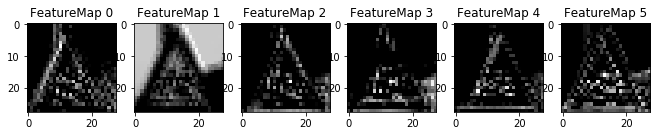

In [74]:
image = mpimg.imread('./traffic-sign-examples/' + sign_images[0])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(image, layer1)